# Setup

Importing the relevant packages

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

In [39]:
import btk
import btk.plot_utils
import btk.survey
import btk.draw_blends
import btk.catalog
import btk.sampling_functions
import btk.metrics
import astropy.table

# Get blends and truth catalogs

We will first explore the image generation part of BTK. We need to provide 3 main elements: the catalog, a sampling function and a survey.

In [40]:
from btk.sampling_functions import DefaultSampling
from btk.catalog import CatsimCatalog

In [41]:
catalog_name = "../data/sample_input_catalog.fits"
catalog = CatsimCatalog.from_file(catalog_name)

seed = 44
stamp_size = 24.0  # Size of the stamp, in arcseconds
max_number = 5     # Maximum number of galaxies in a blend
max_shift = 2.0    # Maximum shift of the galaxies, in arcseconds
sampling_function = DefaultSampling(max_number=max_number, stamp_size=stamp_size,           
                                    maxshift=max_shift, seed=seed) 

LSST = btk.survey.get_surveys("LSST")

draw_generator = btk.draw_blends.CatsimGenerator(
    catalog,
    sampling_function,
    LSST,
    batch_size=10,
    stamp_size=stamp_size,
    cpus=1,
    add_noise="all",
    seed=seed, # same random seed is used here too!
)

Generating blends for LSST survey:   0%|          | 0/10 [00:00<?, ?it/s]

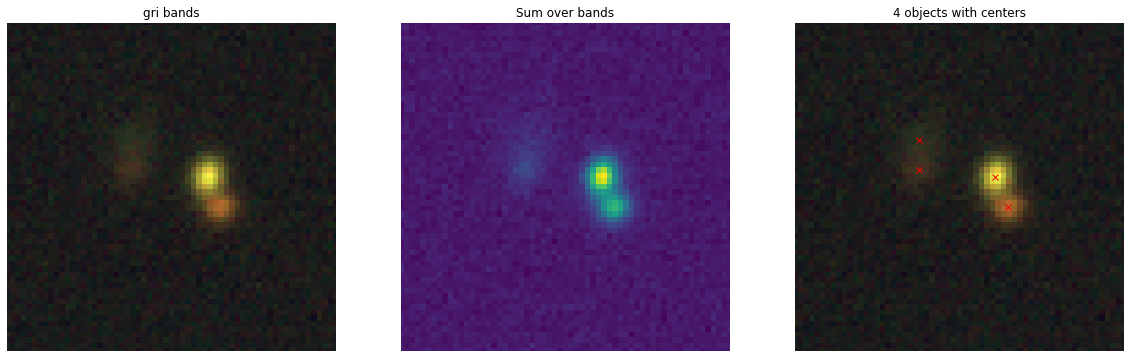

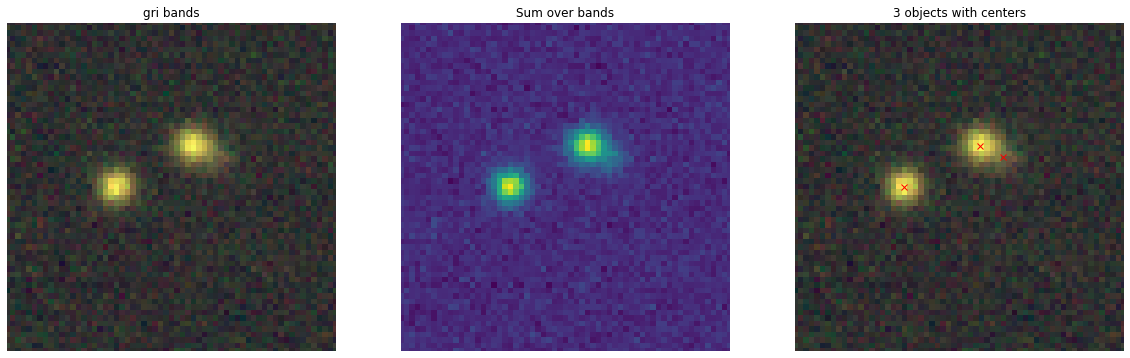

In [42]:
batch = next(draw_generator)
blend_images = batch['blend_images']
blend_list = batch['blend_list'] # list 
iso_images = batch['isolated_images']
btk.plot_utils.plot_blends(blend_images[:2], blend_list[:2], limits=(30,90),norm="asinh",Q=0.1)

The results from the `next` call are stored in the dictionnary; the keys are:
- `blend_images` for the actual blend images
- `isolated_images` for the isolated images 
- `blend_list` for the blend information as a list of astropy tables.
- `psf` for the PSF (as a list of Galsim objects)
- `wcs` for the World Coordinate System corresponding to the images (as a list of astropy.wcs.WCS objects)

Please note that several surveys can be provided as a list to the generator. In that case, each of the entry will contain a dictionnary indexed by the surveys, which in turn contains the results described as above (you would access it with `batch['blend_images']['LSST']` for instance.

**Note:** Fluxes in BTK for these images are calculated using `galcheat` based on the :function:`~galcheat.utilities.mag2counts` function and corresponding survey and filter parameters. Please see the `galcheat` documentation for more details.

In [43]:
# shapes
print(blend_images.shape) # n_blends, n_bands, shape, shape
print(iso_images.shape) # n_blends, max_n_sources, n_bands, shape, shape

(10, 6, 120, 120)
(10, 5, 6, 120, 120)


In [44]:
# blend_list is a list of astropy tables, one per blend 
# i.e. truth catalog for each blends 
blend_list[0]

galtileid,ra,dec,redshift,fluxnorm_bulge,fluxnorm_disk,fluxnorm_agn,a_b,a_d,b_b,b_d,pa_bulge,pa_disk,u_ab,g_ab,r_ab,i_ab,z_ab,y_ab,ref_mag,btk_size,x_peak,y_peak,not_drawn_u,not_drawn_g,not_drawn_r,not_drawn_i,not_drawn_z,not_drawn_y
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2201104165,1.876735792577688,-0.6481522041363306,0.812159895897,6.57883086866e-18,2.26453001134e-17,0.0,0.22702370584,0.191140606999,0.20540009439,0.0433686003089,24.3779182434,24.3779182434,25.9493045807,25.4186573029,24.5099773407,23.527223587,23.0481529236,22.813867569,23.527223587,0.7996899312496969,68.88367896336962,56.25923897889346,0.0,0.0,0.0,0.0,0.0,0.0
2202484794,-1.3507315008577327,0.7108912695221465,0.737505495548,0.0,6.11022188471e-18,0.0,0.0,0.403777301311,0.0,0.195289194584,0.0,232.21925354,26.6245307922,26.2098960876,25.5539073944,24.7192592621,24.4865779877,24.3074092865,24.7192592621,1.88160222410926,52.7463424954463,63.05445634748271,0.0,0.0,0.0,0.0,0.0,0.0
2200813818,1.4291746942270862,0.46613668625563554,0.350970596075,0.0,3.65527208395e-17,0.0,0.0,0.273549705744,0.0,0.0649354979396,0.0,71.0713500977,24.9696521759,24.2869358063,23.410484314,23.070728302,22.8698596954,22.7205543518,23.070728302,1.2747416287670401,66.64587347131031,61.83068343124729,0.0,0.0,0.0,0.0,0.0,0.0
2202778015,-1.347818915715738,1.8197446562739974,0.27325001359,0.0,3.87681686002e-18,0.0,0.0,0.714842677116,0.0,0.70996171236,0.0,303.523345947,26.330493927,25.4907112122,24.8773078918,24.8016204834,24.7664146423,24.7361946106,24.8016204834,3.33116687536056,52.76090542134518,68.59872328165,0.0,0.0,0.0,0.0,0.0,0.0


# Measurement

In [45]:
# we should also get measurements
meas_generator = btk.measure.MeasureGenerator(btk.measure.sep_measure,draw_generator)

In [46]:
# just like draw_blend_generator, we use `next` to do measurements with SEP and get results.
blend_results,meas_results = next(meas_generator)

Generating blends for LSST survey:   0%|          | 0/10 [00:00<?, ?it/s]

In [47]:
# blend_results is exactly the same as call to `next` on draw_blend_generator
blend_results.keys()

dict_keys(['blend_images', 'isolated_images', 'blend_list', 'psf', 'wcs'])

In [48]:
# meas results depends on the measure function, for SEP catalog, segmentation, and deblended_images are returned.
meas_results.keys()

dict_keys(['catalog', 'segmentation', 'deblended_images'])

In [50]:
# catalog key contains a dictionary one per measurement function passed in
# only one for now, SEP
sep_detection_tables = meas_results['catalog']['sep_measure']

# detection_tables is a list of astropy tables, one per blend
sep_detection_tables[0]

ra,dec,x_peak,y_peak
float64,float64,float64,float64
0.8517622104829741,0.7885182988503691,63.75881105243644,63.44259149424437
1295998.6914633706,1.1763825319953976,52.957316852564105,65.38191266018319
1295998.1787401964,-1.8007398815802858,50.39370098140997,50.496300591354895


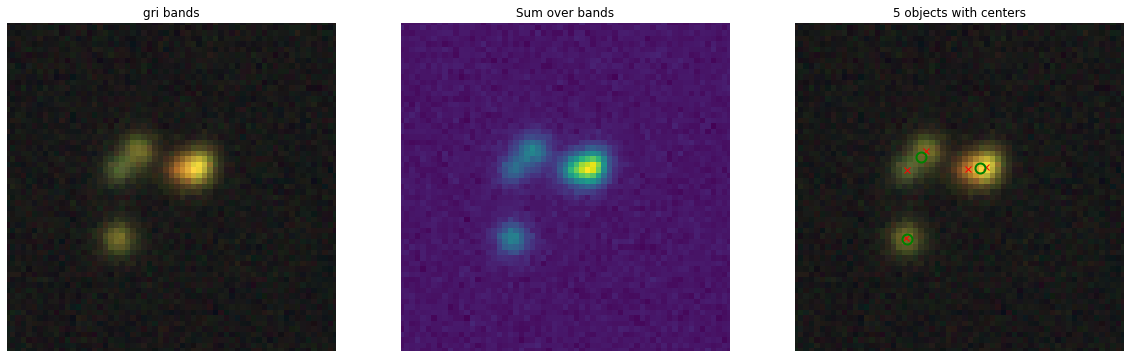

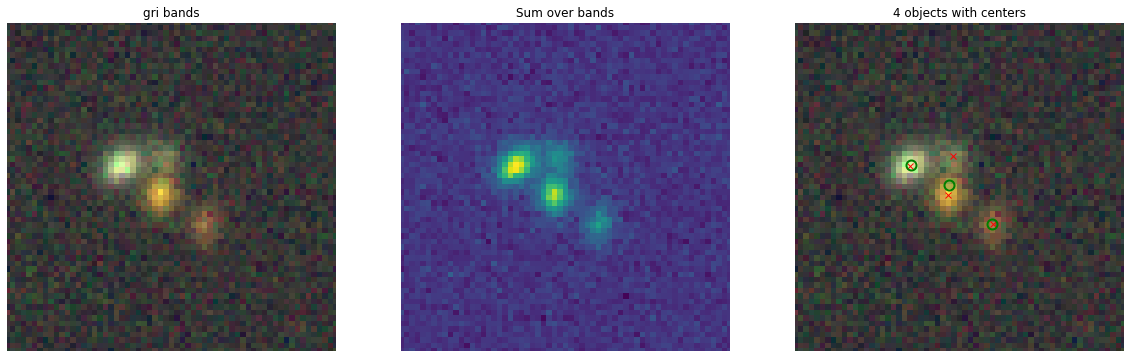

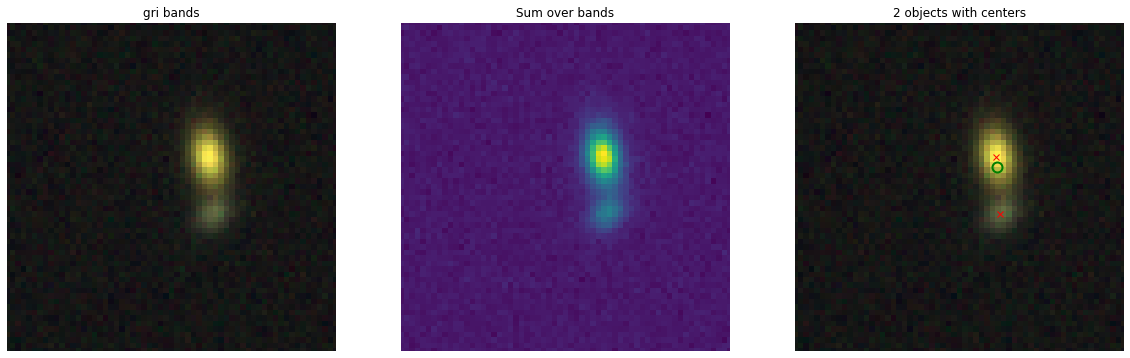

In [69]:
# let us plot them along true catalog for some blends
blend_images = blend_results['blend_images']
blend_list = blend_results['blend_list'] # list 
detected_centers = [np.vstack([c['x_peak'].value, c['y_peak'].value]).T for c in sep_detection_tables][:3] # convert to array of pixel locations

btk.plot_utils.plot_blends(blend_images[:3], blend_list[:3], detected_centers=detected_centers, limits=(30,90),norm="asinh",Q=0.1)

In [79]:
# The segmentation key with the `sep_measure` key contains a list
# each element of the list is an array of shape NHW, where N is the number detections 
segmentations = meas_results['segmentation']['sep_measure']
segmentations[0].shape

(3, 120, 120)

In [80]:
# The deblneded_images for `sep_measure`
# contains a list, one per blend
# each element of the list is an array of NMHW, where N is number of detections, M is number of bands
deblended_images = meas_results['deblended_images']['sep_measure']
deblended_images[0].shape

(3, 6, 120, 120)

# Metrics

API: https://lsstdesc.org/BlendingToolKit/src/btk.metrics.html

In [103]:
from btk.metrics import get_blendedness, get_detection_match, detection_metrics, segmentation_metrics_blend, reconstruction_metrics

In [85]:
# blendedness 
# blendedness is calculated based on isolated images 
# we can use the true images for this
blend_images = blend_results['blend_images']
isolated_images = blend_results['isolated_images']
blend_images.shape, isolated_images.shape

# need to do it one galaxy at a time, one per band
# 0 is no blending almost, 1 is very blended.
get_blendedness(isolated_images[0, 0, 0], blend_images[0, 0]) 

0.9575643544003773

In [89]:
# function to compute distance for matching 
def distance_center(true_gal, detected_gal):
    """Computes the euclidean distance between the two galaxies given as arguments.

    Args:
        true_gal (astropy.table.Table): Contains information related to the true galaxy.
        detected_gal (astropy.table.Table): Contains information related to the detected galaxy
    Returns:
        Distance between the two galaxies
    """
    return np.hypot(
        true_gal["x_peak"] - detected_gal["x_peak"], true_gal["y_peak"] - detected_gal["y_peak"]
    )

In [90]:
# all metrics currently depend on getting matches based on true vs detection catalog 
# create a list of matches, one per blend
blend_list = blend_results['blend_list']
detection_catalogs = meas_results['catalog']['sep_measure']
matches = [
    get_detection_match(
        blend_list[i], detection_catalogs[i], distance_center, 5.0 # threshold is 5 pixels.
    )
    for i in range(len(blend_list))
]

In [91]:
# each element of the matches list contains a table, one row per true object in the catalog
# `match_detected_id` is -1 if no match is found, otherwise index of object in `detection_catalogs`
matches[0]

match_detected_id,dist
int64,float64
-1,0.0
1,1.5223095684144783
-1,0.0
2,0.0943113739870485
0,1.2345970100716885


In [95]:
# compute detection metrics based on matches using tp, fp, fn,...
# get precision, recall, f1, eff_matrix based on matches
# efficiency matrix (how many objects are recovered as a function of objects in blend)
# results are averaged over all blends
results_detection = detection_metrics(detection_catalogs, matches)
results_detection['precision'], results_detection['recall'], results_detection['f1']

(1.0, 0.5769230769230769, 0.7317073170731707)

In [100]:
from galcheat.utilities import mean_sky_level

# compute a reasonable noise threshold based on mean sky level.
noise_threshold = 3 * np.sqrt(
    mean_sky_level(LSST, LSST.get_filter('r')).to_value("electron")
)

# just for first blend
# only metric implemented for segmentation is iou 
# intermetidate segmentation is produced from true isolated images which is why we need noise_threshold.
iou = segmentation_metrics_blend(isolated_images[0], segmentations[0], matches[0], 
                                noise_threshold, 
                                meas_band_num=2) #correspond to 'r' band
# iou only for matches, otherwise nan

[nan, 0.4028776978417266, nan, 0.4864864864864865, 0.48366013071895425]

In [106]:
# dictionary of reconstruction metrics, by default 'msr', 'ssim', 'psnr'
reconstruction = reconstruction_metrics(isolated_images, deblended_images, matches)

# each is a list, one per blend. 
# always indexed on true isolated objects, nan if there was no match
reconstruction['msr']

[[nan, 10456.581935323029, nan, 1261.9113218117138, 38058.38039737994],
 [1424.9953721567883, 822.0163326038372, 3776.4652312927647, nan],
 [nan, 19711.213133716585],
 [999.0764403629732],
 [45163.937131038445],
 [nan, nan, nan, 5442201.969334099],
 [1584.0009338886446],
 [29868.966937637644, nan, nan, 915.4041769825966, nan],
 [744.8903269076192],
 [nan, 647.8338616453307]]